In [1]:
import pandas as pd
import numpy as np
import joblib
import sys
sys.path.append('../')

try:
    from premier_league import (
        constants,
        preprocessing,
        preprocessing_helpers,
        training,
        evaluation,
        prediction,
        data_extraction,
        visualisations,
        s3_helpers,
        postgres,
        mlflow_functions,
        expectations_helpers,
        email_functions,
        data_drift_functions,
    )
except ModuleNotFoundError:
    import constants
    import preprocessing
    import preprocessing_helpers
    import training
    import evaluation
    import prediction
    import data_extraction
    import visualisations
    import s3_helpers
    import postgres
    import mlflow_functions
    import expectations_helpers
    import email_functions
    import data_drift_functions

2023-11-30 07:45:59,799 - PremierLeagueLogger - INFO - Grabbing Passwords


In [2]:
df = s3_helpers.grab_data_s3(constants.TRAINING_DATA_LOCATION)
df = df[constants.COLUMNS_REQ]

2023-11-30 07:46:05,982 - PremierLeagueLogger - INFO - Loading data from premier-league-app/app_data/training_data_full.csv
2023-11-30 07:46:08,884 - PremierLeagueLogger - INFO - Successfully loaded data from premier-league-app/app_data/training_data_full.csv


In [3]:
df.head()

,season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1995-96,19/08/95,Aston Villa,Man United,3.0,1.0,H
1,1995-96,19/08/95,Blackburn,QPR,1.0,0.0,H
2,1995-96,19/08/95,Chelsea,Everton,0.0,0.0,D
3,1995-96,19/08/95,Liverpool,Sheffield Weds,1.0,0.0,H
4,1995-96,19/08/95,Man City,Tottenham,1.0,1.0,D


### Set up data validation

In [4]:
if constants.RUN_DATA_EXPECTATIONS:
    ge_class = expectations_helpers.AutoGreatExpectations(df)

In [5]:
if constants.RUN_DATA_EXPECTATIONS:
    ge_data = ge_class.generate_expectations(verbose=False)

Generating expectations
Done


In [6]:
if constants.RUN_DATA_EXPECTATIONS:
    expectations_helpers.view_suite_summary(ge_data)

2023-11-30 07:46:10,115 - PremierLeagueLogger - INFO - Total Expectations: 18
2023-11-30 07:46:11,256 - PremierLeagueLogger - INFO - Counts:
2023-11-30 07:46:12,403 - PremierLeagueLogger - INFO - expect_column_values_to_be_null: 7
2023-11-30 07:46:13,546 - PremierLeagueLogger - INFO - expect_column_values_to_be_null: 7
2023-11-30 07:46:14,712 - PremierLeagueLogger - INFO - expect_column_values_to_be_of_type: 7
2023-11-30 07:46:15,865 - PremierLeagueLogger - INFO - expect_column_values_to_be_of_type: 7
2023-11-30 07:46:17,023 - PremierLeagueLogger - INFO - expect_column_values_to_be_between: 2
2023-11-30 07:46:18,197 - PremierLeagueLogger - INFO - expect_column_values_to_be_between: 2
2023-11-30 07:46:19,368 - PremierLeagueLogger - INFO - expect_column_values_to_be_in_set: 1
2023-11-30 07:46:20,508 - PremierLeagueLogger - INFO - expect_column_values_to_be_in_set: 1
2023-11-30 07:46:21,711 - PremierLeagueLogger - INFO - expect_table_columns_to_match_set: 1
2023-11-30 07:46:22,881 - Premi

In [7]:
# Save expectations to S3
expectations_helpers.save_expectations(
    ge_data,
    f'app_data/expectations/exp_prem_results_{constants.current_time}.json'
)

2023-11-30 07:46:24,080 - PremierLeagueLogger - INFO - Saving expectations to premier-league-app/app_data/expectations/exp_prem_results_20231130.json
2023-11-30 07:46:26,259 - PremierLeagueLogger - INFO - Saved expectations to premier-league-app/app_data/expectations/exp_prem_results_20231130.json


### Validate data

In [8]:
# Load latest expectations
data_expectations = expectations_helpers.load_latest_expectations(
    expectations_helpers.latest_exp_file()
)

2023-11-30 07:46:28,487 - PremierLeagueLogger - INFO - Looking for latest expectations file
2023-11-30 07:46:29,739 - PremierLeagueLogger - INFO - Loading expectations from premier-league-app/app_data/expectations/exp_prem_results_20231130.json
2023-11-30 07:46:31,629 - PremierLeagueLogger - INFO - Loaded expectations from premier-league-app/app_data/expectations/exp_prem_results_20231130.json


In [9]:
if constants.INITIAL_DATA_LOAD:
    full_data = data_extraction.load_all_data(
        constants.TRAINING_DATA_LOCATION,
        constants.COLUMNS_REQ
    )
else:
    full_data = s3_helpers.grab_data_s3(
        constants.TRAINING_DATA_LOCATION
    )


2023-11-30 07:46:32,903 - PremierLeagueLogger - INFO - Loading data from premier-league-app/app_data/training_data_full.csv
2023-11-30 07:46:35,609 - PremierLeagueLogger - INFO - Successfully loaded data from premier-league-app/app_data/training_data_full.csv


In [10]:
full_data = data_extraction.add_new_data(
    full_data, 
    constants.COLUMNS_REQ,
    constants.TRAINING_DATA_LOCATION
)

2023-11-30 07:46:36,838 - PremierLeagueLogger - INFO - Trying to read data from https://www.football-data.co.uk/mmz4281/2324/E0.csv
2023-11-30 07:46:39,582 - PremierLeagueLogger - INFO - Savng data to premier-league-app/app_data/training_data_full.csv
2023-11-30 07:46:42,636 - PremierLeagueLogger - INFO - Data saved at app_data/training_data_full.csv


In [11]:
validation_results = expectations_helpers.validate_data(
        full_data, 
        data_expectations,
        expectations_path = constants.VALIDATION_RESULTS_PATH
)

2023-11-30 07:46:43,928 - PremierLeagueLogger - INFO - {'evaluated_expectations': 18, 'successful_expectations': 18, 'unsuccessful_expectations': 0, 'success_percent': 100.0}
2023-11-30 07:46:45,124 - PremierLeagueLogger - INFO - Saving expectations to premier-league-app/app_data/expectations/valid_results_20231130.json
2023-11-30 07:46:47,358 - PremierLeagueLogger - INFO - Saved expectations to premier-league-app/app_data/expectations/valid_results_20231130.json


In [12]:
if not validation_results['success']:
    email_functions.send_email(
        'data_validation',
        constants.S3_BUCKET, 
        expectations_helpers.latest_exp_file(),
        constants.VALIDATION_TOPIC, 
    )
    raise Exception('Stopping Pipeline. Validation has failed')

### Data Drift Detection

In [13]:
# Load historical data
historical = s3_helpers.grab_data_s3(
    constants.HISTORICAL_DATA_DRIFT
)

2023-11-30 07:46:48,651 - PremierLeagueLogger - INFO - Loading data from premier-league-app/app_data/historical_pl_data.csv
2023-11-30 07:46:51,541 - PremierLeagueLogger - INFO - Successfully loaded data from premier-league-app/app_data/historical_pl_data.csv


In [14]:
data_drift = data_drift_functions.DriftDetector(
    historical,
    full_data
)

In [15]:
drift_report = data_drift.check_data_drift(
    constants.DRIFT_REPORT_LOC
)

2023-11-30 07:46:53,986 - PremierLeagueLogger - INFO - Saving drift report to premier-league-app/app_data/data_drift_reports/drift_report_20231130.html
INFO:PremierLeagueLogger:Saving drift report to premier-league-app/app_data/data_drift_reports/drift_report_20231130.html
2023-11-30 07:46:58,589 - PremierLeagueLogger - INFO - Saved drift report to premier-league-app/app_data/data_drift_reports/drift_report_20231130.html
INFO:PremierLeagueLogger:Saved drift report to premier-league-app/app_data/data_drift_reports/drift_report_20231130.html


{'drift_share': 0.5, 'number_of_columns': 7, 'number_of_drifted_columns': 0, 'share_of_drifted_columns': 0.0, 'dataset_drift': False}


### Preprocessing

In [16]:
df = s3_helpers.grab_data_s3(constants.TRAINING_DATA_LOCATION)
df = df[constants.COLUMNS_REQ]
df.head()

2023-11-30 07:46:59,922 - PremierLeagueLogger - INFO - Loading data from premier-league-app/app_data/training_data_full.csv
INFO:PremierLeagueLogger:Loading data from premier-league-app/app_data/training_data_full.csv
2023-11-30 07:47:02,642 - PremierLeagueLogger - INFO - Successfully loaded data from premier-league-app/app_data/training_data_full.csv
INFO:PremierLeagueLogger:Successfully loaded data from premier-league-app/app_data/training_data_full.csv


,season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1995-96,19/08/95,Aston Villa,Man United,3.0,1.0,H
1,1995-96,19/08/95,Blackburn,QPR,1.0,0.0,H
2,1995-96,19/08/95,Chelsea,Everton,0.0,0.0,D
3,1995-96,19/08/95,Liverpool,Sheffield Weds,1.0,0.0,H
4,1995-96,19/08/95,Man City,Tottenham,1.0,1.0,D


In [17]:
transformers = preprocessing.fit_transformers(
    df
)

2023-11-30 07:47:03,898 - PremierLeagueLogger - INFO - Fitting Transformer
INFO:PremierLeagueLogger:Fitting Transformer
2023-11-30 07:47:05,064 - PremierLeagueLogger - INFO - Fitting Transformer
INFO:PremierLeagueLogger:Fitting Transformer


In [18]:
s3_helpers.save_transformer_s3_pickle(
    transformers, 
    constants.TRANSFORMER_PATH
)

2023-11-30 07:47:34,128 - PremierLeagueLogger - INFO - Saving transformer to premier-league-app/app_data/transformers/transformer_v2_20231130.pkl
INFO:PremierLeagueLogger:Saving transformer to premier-league-app/app_data/transformers/transformer_v2_20231130.pkl
2023-11-30 07:47:36,633 - PremierLeagueLogger - INFO - Transformer saved to premier-league-app/app_data/transformers/transformer_v2_20231130.pkl
INFO:PremierLeagueLogger:Transformer saved to premier-league-app/app_data/transformers/transformer_v2_20231130.pkl


In [19]:
transformed_data = preprocessing.transform_data(
    df, transformers
)

2023-11-30 07:47:37,928 - PremierLeagueLogger - INFO - Transforming Data
INFO:PremierLeagueLogger:Transforming Data
2023-11-30 07:47:39,227 - PremierLeagueLogger - INFO - Transforming Data
INFO:PremierLeagueLogger:Transforming Data


In [20]:
#transformed_data = transformed_data.drop(['HomeTeam', 'AwayTeam', 'season'], axis=1)

In [21]:
training_data, testing_data = preprocessing.split_data(transformed_data)

2023-11-30 07:48:06,441 - PremierLeagueLogger - INFO - Splitting Data
INFO:PremierLeagueLogger:Splitting Data


In [22]:
training_data.shape

(8616, 33)

In [23]:
testing_data.shape

(2154, 33)

In [24]:
training_data.head(2)

,season,HomeTeam,AwayTeam,FTR,HTGS,ATGS,HTGC,ATGC,HTP,ATP,...,HTGD,ATGD,DiffPts,DiffFormPts,HomeLeaguePosition,AwayLeaguePosition,LeaguePositionDiff,MatchDayDay,MatchDayMonth,MatchDayDate
0,1995-96,Man United,Nott'm Forest,0,65.0,46.0,35.0,53.0,2.054054,1.459459,...,0.810811,-0.189189,0.594595,0.135135,2,7,-5,Sunday,April,28
1,2001-02,Man United,Sunderland,0,56.0,19.0,34.0,26.0,1.800000,1.120000,...,0.880000,-0.280000,0.680000,0.400000,3,13,-10,Saturday,February,2


### Model Training

In [25]:
target_column = 'FTR'

In [26]:
hyperparameters = training.optimise_hyperparameters(
    training_data,
    target_column,
    max_evals = constants.MAX_EVALS
)

2023-11-30 07:48:07,992 - PremierLeagueLogger - INFO - Optimising Hyperparameters
INFO:PremierLeagueLogger:Optimising Hyperparameters
2023-11-30 07:48:09,258 - PremierLeagueLogger - INFO - Entering fmin
INFO:PremierLeagueLogger:Entering fmin


  0%|                                                                                                                                                                 | 0/20 [00:00<?, ?trial/s, best loss=?]

2023-11-30 07:48:10,559 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 07:48:11,800 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 07:48:16,028 - PremierLeagueLogger - INFO - Loss: -0.5185614849187935
INFO:PremierLeagueLogger:Loss: -0.5185614849187935


  5%|██████▋                                                                                                                               | 1/20 [00:07<02:14,  7.07s/trial, best loss: -0.5185614849187935]

2023-11-30 07:48:17,626 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 07:48:18,803 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 07:48:23,564 - PremierLeagueLogger - INFO - Loss: -0.5284222737819025
INFO:PremierLeagueLogger:Loss: -0.5284222737819025


 10%|█████████████▍                                                                                                                        | 2/20 [00:14<02:10,  7.24s/trial, best loss: -0.5284222737819025]

2023-11-30 07:48:24,985 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 07:48:26,214 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 07:48:31,315 - PremierLeagueLogger - INFO - Loss: -0.5191415313225058
INFO:PremierLeagueLogger:Loss: -0.5191415313225058


 15%|████████████████████                                                                                                                  | 3/20 [00:21<02:05,  7.37s/trial, best loss: -0.5284222737819025]

2023-11-30 07:48:32,499 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 07:48:33,691 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 07:48:35,836 - PremierLeagueLogger - INFO - Loss: -0.521461716937355
INFO:PremierLeagueLogger:Loss: -0.521461716937355


 20%|██████████████████████████▊                                                                                                           | 4/20 [00:26<01:40,  6.27s/trial, best loss: -0.5284222737819025]

2023-11-30 07:48:37,084 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 07:48:38,252 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 07:48:40,787 - PremierLeagueLogger - INFO - Loss: -0.5197215777262181
INFO:PremierLeagueLogger:Loss: -0.5197215777262181


 25%|█████████████████████████████████▌                                                                                                    | 5/20 [00:31<01:26,  5.78s/trial, best loss: -0.5284222737819025]

2023-11-30 07:48:42,267 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 07:48:43,421 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 07:48:45,764 - PremierLeagueLogger - INFO - Loss: -0.5226218097447796
INFO:PremierLeagueLogger:Loss: -0.5226218097447796


 30%|████████████████████████████████████████▏                                                                                             | 6/20 [00:36<01:17,  5.52s/trial, best loss: -0.5284222737819025]

2023-11-30 07:48:47,010 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 07:48:48,173 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 07:48:49,825 - PremierLeagueLogger - INFO - Loss: -0.5220417633410673
INFO:PremierLeagueLogger:Loss: -0.5220417633410673


 35%|██████████████████████████████████████████████▉                                                                                       | 7/20 [00:40<01:05,  5.02s/trial, best loss: -0.5284222737819025]

2023-11-30 07:48:51,008 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 07:48:52,178 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 07:48:58,016 - PremierLeagueLogger - INFO - Loss: -0.527262180974478
INFO:PremierLeagueLogger:Loss: -0.527262180974478


 40%|█████████████████████████████████████████████████████▌                                                                                | 8/20 [00:48<01:13,  6.10s/trial, best loss: -0.5284222737819025]

2023-11-30 07:48:59,413 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 07:49:00,586 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 07:49:03,124 - PremierLeagueLogger - INFO - Loss: -0.5197215777262181
INFO:PremierLeagueLogger:Loss: -0.5197215777262181


 45%|████████████████████████████████████████████████████████████▎                                                                         | 9/20 [00:53<01:02,  5.72s/trial, best loss: -0.5284222737819025]

2023-11-30 07:49:04,308 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 07:49:05,501 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 07:49:07,425 - PremierLeagueLogger - INFO - Loss: -0.5243619489559165
INFO:PremierLeagueLogger:Loss: -0.5243619489559165


 50%|██████████████████████████████████████████████████████████████████▌                                                                  | 10/20 [00:58<00:52,  5.29s/trial, best loss: -0.5284222737819025]

2023-11-30 07:49:08,614 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 07:49:09,818 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 07:49:12,317 - PremierLeagueLogger - INFO - Loss: -0.5295823665893271
INFO:PremierLeagueLogger:Loss: -0.5295823665893271


 55%|█████████████████████████████████████████████████████████████████████████▏                                                           | 11/20 [01:02<00:46,  5.17s/trial, best loss: -0.5295823665893271]

2023-11-30 07:49:13,513 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 07:49:14,873 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 07:49:18,089 - PremierLeagueLogger - INFO - Loss: -0.5220417633410673
INFO:PremierLeagueLogger:Loss: -0.5220417633410673


 60%|███████████████████████████████████████████████████████████████████████████████▊                                                     | 12/20 [01:08<00:42,  5.37s/trial, best loss: -0.5295823665893271]

2023-11-30 07:49:19,342 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 07:49:20,535 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 07:49:22,535 - PremierLeagueLogger - INFO - Loss: -0.5220417633410673
INFO:PremierLeagueLogger:Loss: -0.5220417633410673


 65%|██████████████████████████████████████████████████████████████████████████████████████▍                                              | 13/20 [01:13<00:35,  5.07s/trial, best loss: -0.5295823665893271]

2023-11-30 07:49:23,727 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 07:49:24,909 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 07:49:27,170 - PremierLeagueLogger - INFO - Loss: -0.5046403712296984
INFO:PremierLeagueLogger:Loss: -0.5046403712296984


 70%|█████████████████████████████████████████████████████████████████████████████████████████████                                        | 14/20 [01:17<00:29,  4.94s/trial, best loss: -0.5295823665893271]

2023-11-30 07:49:28,364 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 07:49:29,565 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 07:49:31,701 - PremierLeagueLogger - INFO - Loss: -0.5237819025522041
INFO:PremierLeagueLogger:Loss: -0.5237819025522041


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 15/20 [01:22<00:24,  4.83s/trial, best loss: -0.5295823665893271]

2023-11-30 07:49:32,957 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 07:49:34,186 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 07:49:35,884 - PremierLeagueLogger - INFO - Loss: -0.5208816705336426
INFO:PremierLeagueLogger:Loss: -0.5208816705336426


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 16/20 [01:26<00:18,  4.62s/trial, best loss: -0.5295823665893271]

2023-11-30 07:49:37,074 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 07:49:38,278 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 07:49:41,250 - PremierLeagueLogger - INFO - Loss: -0.527262180974478
INFO:PremierLeagueLogger:Loss: -0.527262180974478


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 17/20 [01:31<00:14,  4.84s/trial, best loss: -0.5295823665893271]

2023-11-30 07:49:42,447 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 07:49:43,796 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 07:49:46,264 - PremierLeagueLogger - INFO - Loss: -0.5290023201856149
INFO:PremierLeagueLogger:Loss: -0.5290023201856149


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 18/20 [01:37<00:09,  4.94s/trial, best loss: -0.5295823665893271]

2023-11-30 07:49:47,618 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 07:49:48,977 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 07:49:51,937 - PremierLeagueLogger - INFO - Loss: -0.5174013921113689
INFO:PremierLeagueLogger:Loss: -0.5174013921113689


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 19/20 [01:42<00:05,  5.17s/trial, best loss: -0.5295823665893271]

2023-11-30 07:49:53,308 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 07:49:54,682 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 07:49:56,916 - PremierLeagueLogger - INFO - Loss: -0.5220417633410673
INFO:PremierLeagueLogger:Loss: -0.5220417633410673


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:47<00:00,  5.39s/trial, best loss: -0.5295823665893271]


In [27]:
print(hyperparameters)

{'learning_rate': 0.1, 'iterations': 500, 'max_depth': 6}


In [28]:
# Start postgresDB for model logging
if postgres.get_instance_status(
        constants.POSTGRES_DB_ID) != 'available':
    postgres.start_rds_instance(constants.POSTGRES_DB_ID)

2023-11-30 07:49:58,365 - PremierLeagueLogger - INFO - Grabbing instance status of premier-league-logging
INFO:PremierLeagueLogger:Grabbing instance status of premier-league-logging
2023-11-30 07:50:01,927 - PremierLeagueLogger - INFO - Starting RDS instance 'premier-league-logging'
INFO:PremierLeagueLogger:Starting RDS instance 'premier-league-logging'
2023-11-30 07:50:04,225 - PremierLeagueLogger - INFO - RDS instance status:'premier-league-logging': starting
INFO:PremierLeagueLogger:RDS instance status:'premier-league-logging': starting
2023-11-30 07:52:06,940 - PremierLeagueLogger - INFO - RDS instance status:'premier-league-logging': starting
INFO:PremierLeagueLogger:RDS instance status:'premier-league-logging': starting
2023-11-30 07:54:10,025 - PremierLeagueLogger - INFO - RDS instance status:'premier-league-logging': starting
INFO:PremierLeagueLogger:RDS instance status:'premier-league-logging': starting
2023-11-30 07:56:13,355 - PremierLeagueLogger - INFO - RDS instance status

In [29]:
# Open mlflow tracking
mlflow_functions.open_mlflow_tracking(
    constants.EXP_NAME
)

In [30]:
classifier, run_id = training.train_model(
    training_data[[col for col in training_data if col != target_column]],
    training_data[target_column],
    hyperparameters = hyperparameters
)

2023-11-30 07:58:27,756 - PremierLeagueLogger - INFO - Training Model
INFO:PremierLeagueLogger:Training Model
2023-11-30 07:58:41,897 - PremierLeagueLogger - INFO - Logging parameters to MLFlow
INFO:PremierLeagueLogger:Logging parameters to MLFlow

The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives




In [31]:
s3_helpers.save_transformer_s3_pickle(
    classifier, 
    constants.CLASS_MODEL_NAME,
    is_transformer=False
)

2023-11-30 07:58:57,116 - PremierLeagueLogger - INFO - Saving transformer to premier-league-app/app_data/models/classifier_v2_20231130.pkl
INFO:PremierLeagueLogger:Saving transformer to premier-league-app/app_data/models/classifier_v2_20231130.pkl
2023-11-30 07:59:01,495 - PremierLeagueLogger - INFO - Transformer saved to premier-league-app/app_data/models/classifier_v2_20231130.pkl
INFO:PremierLeagueLogger:Transformer saved to premier-league-app/app_data/models/classifier_v2_20231130.pkl


### Prediction

In [32]:
y_test = testing_data[target_column]
x_test = testing_data[[col for col in testing_data if col != target_column]]

In [33]:
predictions = prediction.predict(x_test, classifier)

2023-11-30 07:59:02,949 - PremierLeagueLogger - INFO - Making Predictions
INFO:PremierLeagueLogger:Making Predictions


### Evaluation

In [34]:
evaluation_metrics = evaluation.evaluate_model(
    predictions, 
    y_test,
    model_type='result',
    run_id=run_id
)

2023-11-30 07:59:04,418 - PremierLeagueLogger - INFO - Evaluating result model
INFO:PremierLeagueLogger:Evaluating result model
2023-11-30 07:59:10,557 - PremierLeagueLogger - INFO - logging evaluation metrics to mlflow
INFO:PremierLeagueLogger:logging evaluation metrics to mlflow


In [35]:
evaluation_metrics

{'mcc': 0.2118528972621912,
 'accuracy': 0.5139275766016713,
 'f1': 0.4886819812009435,
 'confusion_matrix': [[723, 90, 185], [299, 96, 136], [264, 73, 288]]}

### Part 2: Predict Score

In [36]:
transformed_data = prediction.add_match_result(
    transformed_data, classifier, df )

2023-11-30 07:59:17,574 - PremierLeagueLogger - INFO - Making Predictions
INFO:PremierLeagueLogger:Making Predictions


In [37]:
s3_helpers.save_data_s3(
    transformed_data,
    constants.TRANSFORMED_DATA_LOCATION
)

2023-11-30 07:59:19,356 - PremierLeagueLogger - INFO - Savng data to premier-league-app/app_data/transformed_data_cc.csv
INFO:PremierLeagueLogger:Savng data to premier-league-app/app_data/transformed_data_cc.csv


In [38]:
transformed_data.shape

(10770, 36)

In [39]:
training_data, testing_data = preprocessing.split_data(transformed_data)

2023-11-30 07:59:23,473 - PremierLeagueLogger - INFO - Splitting Data
INFO:PremierLeagueLogger:Splitting Data


In [40]:
hyperparameters = training.optimise_hyperparameters(
    training_data.drop(['FTR','FTAG'], axis=1),
    'FTHG',
    classification=False,
    max_evals=constants.MAX_EVALS
)

2023-11-30 07:59:24,977 - PremierLeagueLogger - INFO - Optimising Hyperparameters
INFO:PremierLeagueLogger:Optimising Hyperparameters
2023-11-30 07:59:26,459 - PremierLeagueLogger - INFO - Entering fmin
INFO:PremierLeagueLogger:Entering fmin


  0%|                                                                                                                                                                 | 0/20 [00:00<?, ?trial/s, best loss=?]

2023-11-30 07:59:27,912 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 07:59:29,328 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 07:59:32,609 - PremierLeagueLogger - INFO - Loss: 1.4573970712166064
INFO:PremierLeagueLogger:Loss: 1.4573970712166064


  5%|██████▊                                                                                                                                | 1/20 [00:06<01:56,  6.15s/trial, best loss: 1.4573970712166064]

2023-11-30 07:59:34,080 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 07:59:35,537 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 07:59:39,976 - PremierLeagueLogger - INFO - Loss: 1.4573514249913422
INFO:PremierLeagueLogger:Loss: 1.4573514249913422


 10%|█████████████▌                                                                                                                         | 2/20 [00:13<02:04,  6.89s/trial, best loss: 1.4573514249913422]

2023-11-30 07:59:41,476 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 07:59:42,987 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 07:59:45,782 - PremierLeagueLogger - INFO - Loss: 1.4649179178626002
INFO:PremierLeagueLogger:Loss: 1.4649179178626002


 15%|████████████████████▎                                                                                                                  | 3/20 [00:19<01:49,  6.43s/trial, best loss: 1.4573514249913422]

2023-11-30 07:59:47,361 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 07:59:49,082 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 07:59:51,604 - PremierLeagueLogger - INFO - Loss: 1.4554663061188542
INFO:PremierLeagueLogger:Loss: 1.4554663061188542


 20%|███████████████████████████                                                                                                            | 4/20 [00:26<01:49,  6.82s/trial, best loss: 1.4554663061188542]

2023-11-30 07:59:54,794 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 07:59:56,326 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:00:01,037 - PremierLeagueLogger - INFO - Loss: 1.4572228423239117
INFO:PremierLeagueLogger:Loss: 1.4572228423239117


 25%|█████████████████████████████████▊                                                                                                     | 5/20 [00:34<01:47,  7.18s/trial, best loss: 1.4554663061188542]

2023-11-30 08:00:02,598 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:00:04,253 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:00:06,762 - PremierLeagueLogger - INFO - Loss: 1.4600434287120547
INFO:PremierLeagueLogger:Loss: 1.4600434287120547


 30%|████████████████████████████████████████▌                                                                                              | 6/20 [00:40<01:33,  6.65s/trial, best loss: 1.4554663061188542]

2023-11-30 08:00:08,221 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:00:09,673 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:00:11,416 - PremierLeagueLogger - INFO - Loss: 1.4571244749979722
INFO:PremierLeagueLogger:Loss: 1.4571244749979722


 35%|███████████████████████████████████████████████▎                                                                                       | 7/20 [00:44<01:17,  5.99s/trial, best loss: 1.4554663061188542]

2023-11-30 08:00:12,845 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:00:14,297 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:00:15,998 - PremierLeagueLogger - INFO - Loss: 1.456732934373109
INFO:PremierLeagueLogger:Loss: 1.456732934373109


 40%|██████████████████████████████████████████████████████                                                                                 | 8/20 [00:50<01:10,  5.87s/trial, best loss: 1.4554663061188542]

2023-11-30 08:00:18,449 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:00:20,043 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:00:21,815 - PremierLeagueLogger - INFO - Loss: 1.469139976113308
INFO:PremierLeagueLogger:Loss: 1.469139976113308


 45%|████████████████████████████████████████████████████████████▊                                                                          | 9/20 [00:55<01:00,  5.51s/trial, best loss: 1.4554663061188542]

2023-11-30 08:00:23,181 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:00:24,572 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:00:26,216 - PremierLeagueLogger - INFO - Loss: 1.457928644229749
INFO:PremierLeagueLogger:Loss: 1.457928644229749


 50%|███████████████████████████████████████████████████████████████████                                                                   | 10/20 [00:59<00:51,  5.18s/trial, best loss: 1.4554663061188542]

2023-11-30 08:00:27,617 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:00:29,015 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:00:30,654 - PremierLeagueLogger - INFO - Loss: 1.456732934373109
INFO:PremierLeagueLogger:Loss: 1.456732934373109


 55%|█████████████████████████████████████████████████████████████████████████▋                                                            | 11/20 [01:04<00:44,  4.97s/trial, best loss: 1.4554663061188542]

2023-11-30 08:00:32,126 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:00:33,525 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:00:35,324 - PremierLeagueLogger - INFO - Loss: 1.4587971999948308
INFO:PremierLeagueLogger:Loss: 1.4587971999948308


 60%|████████████████████████████████████████████████████████████████████████████████▍                                                     | 12/20 [01:08<00:38,  4.85s/trial, best loss: 1.4554663061188542]

2023-11-30 08:00:36,702 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:00:38,209 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:00:40,274 - PremierLeagueLogger - INFO - Loss: 1.455130426658375
INFO:PremierLeagueLogger:Loss: 1.455130426658375


 65%|███████████████████████████████████████████████████████████████████████████████████████▊                                               | 13/20 [01:13<00:34,  4.89s/trial, best loss: 1.455130426658375]

2023-11-30 08:00:41,663 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:00:43,218 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:00:45,592 - PremierLeagueLogger - INFO - Loss: 1.4566679767808797
INFO:PremierLeagueLogger:Loss: 1.4566679767808797


 70%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 14/20 [01:19<00:30,  5.01s/trial, best loss: 1.455130426658375]

2023-11-30 08:00:46,963 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:00:48,325 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:00:49,862 - PremierLeagueLogger - INFO - Loss: 1.457928644229749
INFO:PremierLeagueLogger:Loss: 1.457928644229749


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 15/20 [01:23<00:24,  4.82s/trial, best loss: 1.455130426658375]

2023-11-30 08:00:51,337 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:00:52,806 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:00:54,638 - PremierLeagueLogger - INFO - Loss: 1.4965449452924438
INFO:PremierLeagueLogger:Loss: 1.4965449452924438


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 16/20 [01:28<00:19,  4.78s/trial, best loss: 1.455130426658375]

2023-11-30 08:00:56,021 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:00:57,484 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:00:59,073 - PremierLeagueLogger - INFO - Loss: 1.458243084976992
INFO:PremierLeagueLogger:Loss: 1.458243084976992


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 17/20 [01:32<00:14,  4.68s/trial, best loss: 1.455130426658375]

2023-11-30 08:01:00,477 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:01:01,873 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:01:03,505 - PremierLeagueLogger - INFO - Loss: 1.4571244749979722
INFO:PremierLeagueLogger:Loss: 1.4571244749979722


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 18/20 [01:36<00:09,  4.60s/trial, best loss: 1.455130426658375]

2023-11-30 08:01:04,881 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:01:06,271 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:01:07,939 - PremierLeagueLogger - INFO - Loss: 1.4563917749396866
INFO:PremierLeagueLogger:Loss: 1.4563917749396866


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 19/20 [01:41<00:04,  4.55s/trial, best loss: 1.455130426658375]

2023-11-30 08:01:09,331 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:01:10,729 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:01:12,593 - PremierLeagueLogger - INFO - Loss: 1.4587971999948308
INFO:PremierLeagueLogger:Loss: 1.4587971999948308


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:46<00:00,  5.31s/trial, best loss: 1.455130426658375]


In [41]:
regressor_1, run_id_home = training.train_model(
    training_data.drop(['FTR', 'FTHG','FTAG'], axis=1),
    training_data['FTHG'],
    model_type='home',
    verbose=False,
    hyperparameters = hyperparameters
)

2023-11-30 08:01:14,082 - PremierLeagueLogger - INFO - Training Model
INFO:PremierLeagueLogger:Training Model
2023-11-30 08:01:29,984 - PremierLeagueLogger - INFO - Logging parameters to MLFlow
INFO:PremierLeagueLogger:Logging parameters to MLFlow

The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives




In [42]:
s3_helpers.save_transformer_s3_pickle(
    regressor_1, 
    constants.HOME_MODEL_NAME,
    is_transformer=False
)

2023-11-30 08:01:43,431 - PremierLeagueLogger - INFO - Saving transformer to premier-league-app/app_data/models/home_regress_model_v2_20231130.pkl
INFO:PremierLeagueLogger:Saving transformer to premier-league-app/app_data/models/home_regress_model_v2_20231130.pkl
2023-11-30 08:01:53,148 - PremierLeagueLogger - INFO - Transformer saved to premier-league-app/app_data/models/home_regress_model_v2_20231130.pkl
INFO:PremierLeagueLogger:Transformer saved to premier-league-app/app_data/models/home_regress_model_v2_20231130.pkl


In [43]:
hyperparameters = training.optimise_hyperparameters(
    training_data.drop(['FTR', 'FTHG'], axis=1),
    'FTAG',
    classification=False,
    max_evals=constants.MAX_EVALS
)

2023-11-30 08:01:54,651 - PremierLeagueLogger - INFO - Optimising Hyperparameters
INFO:PremierLeagueLogger:Optimising Hyperparameters
2023-11-30 08:01:56,113 - PremierLeagueLogger - INFO - Entering fmin
INFO:PremierLeagueLogger:Entering fmin


  0%|                                                                                                                                                                 | 0/20 [00:00<?, ?trial/s, best loss=?]

2023-11-30 08:01:57,523 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:01:58,934 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:02:04,872 - PremierLeagueLogger - INFO - Loss: 1.1675952183932463
INFO:PremierLeagueLogger:Loss: 1.1675952183932463


  5%|██████▊                                                                                                                                | 1/20 [00:09<02:51,  9.03s/trial, best loss: 1.1675952183932463]

2023-11-30 08:02:06,556 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:02:07,990 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:02:10,472 - PremierLeagueLogger - INFO - Loss: 1.1610289415974127
INFO:PremierLeagueLogger:Loss: 1.1610289415974127


 10%|█████████████▌                                                                                                                         | 2/20 [00:14<02:03,  6.85s/trial, best loss: 1.1610289415974127]

2023-11-30 08:02:11,885 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:02:13,325 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:02:15,173 - PremierLeagueLogger - INFO - Loss: 1.156919161353201
INFO:PremierLeagueLogger:Loss: 1.156919161353201


 15%|████████████████████▍                                                                                                                   | 3/20 [00:19<01:40,  5.90s/trial, best loss: 1.156919161353201]

2023-11-30 08:02:16,637 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:02:18,019 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:02:19,690 - PremierLeagueLogger - INFO - Loss: 1.158504377831888
INFO:PremierLeagueLogger:Loss: 1.158504377831888


 20%|███████████████████████████▏                                                                                                            | 4/20 [00:23<01:25,  5.34s/trial, best loss: 1.156919161353201]

2023-11-30 08:02:21,140 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:02:22,611 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:02:24,298 - PremierLeagueLogger - INFO - Loss: 1.1557390991189571
INFO:PremierLeagueLogger:Loss: 1.1557390991189571


 25%|█████████████████████████████████▊                                                                                                     | 5/20 [00:28<01:16,  5.08s/trial, best loss: 1.1557390991189571]

2023-11-30 08:02:25,742 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:02:27,260 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:02:29,110 - PremierLeagueLogger - INFO - Loss: 1.1701639060661235
INFO:PremierLeagueLogger:Loss: 1.1701639060661235


 30%|████████████████████████████████████████▌                                                                                              | 6/20 [00:33<01:10,  5.01s/trial, best loss: 1.1557390991189571]

2023-11-30 08:02:30,614 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:02:32,070 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:02:35,171 - PremierLeagueLogger - INFO - Loss: 1.164125419588544
INFO:PremierLeagueLogger:Loss: 1.164125419588544


 35%|███████████████████████████████████████████████▎                                                                                       | 7/20 [00:39<01:10,  5.41s/trial, best loss: 1.1557390991189571]

2023-11-30 08:02:36,852 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:02:38,240 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:02:39,892 - PremierLeagueLogger - INFO - Loss: 1.1680232402658206
INFO:PremierLeagueLogger:Loss: 1.1680232402658206


 40%|██████████████████████████████████████████████████████                                                                                 | 8/20 [00:43<01:01,  5.13s/trial, best loss: 1.1557390991189571]

2023-11-30 08:02:41,394 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:02:42,977 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:02:44,909 - PremierLeagueLogger - INFO - Loss: 1.1644905406816146
INFO:PremierLeagueLogger:Loss: 1.1644905406816146


 45%|████████████████████████████████████████████████████████████▊                                                                          | 9/20 [00:48<00:56,  5.12s/trial, best loss: 1.1557390991189571]

2023-11-30 08:02:46,496 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:02:48,019 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:02:54,919 - PremierLeagueLogger - INFO - Loss: 1.1675952183932463
INFO:PremierLeagueLogger:Loss: 1.1675952183932463


 50%|███████████████████████████████████████████████████████████████████                                                                   | 10/20 [00:58<01:06,  6.62s/trial, best loss: 1.1557390991189571]

2023-11-30 08:02:56,461 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:02:57,957 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:02:59,758 - PremierLeagueLogger - INFO - Loss: 1.1602511697599105
INFO:PremierLeagueLogger:Loss: 1.1602511697599105


 55%|█████████████████████████████████████████████████████████████████████████▋                                                            | 11/20 [01:03<00:54,  6.06s/trial, best loss: 1.1557390991189571]

2023-11-30 08:03:01,252 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:03:02,774 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:03:08,480 - PremierLeagueLogger - INFO - Loss: 1.1675952183932463
INFO:PremierLeagueLogger:Loss: 1.1675952183932463


 60%|████████████████████████████████████████████████████████████████████████████████▍                                                     | 12/20 [01:12<00:55,  6.92s/trial, best loss: 1.1557390991189571]

2023-11-30 08:03:10,138 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:03:11,639 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:03:13,539 - PremierLeagueLogger - INFO - Loss: 1.1572916638563038
INFO:PremierLeagueLogger:Loss: 1.1572916638563038


 65%|███████████████████████████████████████████████████████████████████████████████████████                                               | 13/20 [01:17<00:44,  6.30s/trial, best loss: 1.1557390991189571]

2023-11-30 08:03:15,022 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:03:16,574 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:03:18,595 - PremierLeagueLogger - INFO - Loss: 1.1654881738893172
INFO:PremierLeagueLogger:Loss: 1.1654881738893172


 70%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 14/20 [01:22<00:35,  5.92s/trial, best loss: 1.1557390991189571]

2023-11-30 08:03:20,062 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:03:21,519 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:03:23,986 - PremierLeagueLogger - INFO - Loss: 1.157871548318671
INFO:PremierLeagueLogger:Loss: 1.157871548318671


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 15/20 [01:28<00:29,  5.83s/trial, best loss: 1.1557390991189571]

2023-11-30 08:03:25,674 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:03:27,142 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:03:29,246 - PremierLeagueLogger - INFO - Loss: 1.1634660414307492
INFO:PremierLeagueLogger:Loss: 1.1634660414307492


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 16/20 [01:33<00:22,  5.59s/trial, best loss: 1.1557390991189571]

2023-11-30 08:03:30,718 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:03:32,321 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:03:34,093 - PremierLeagueLogger - INFO - Loss: 1.1582704652117253
INFO:PremierLeagueLogger:Loss: 1.1582704652117253


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 17/20 [01:38<00:16,  5.38s/trial, best loss: 1.1557390991189571]

2023-11-30 08:03:35,595 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:03:37,072 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:03:38,895 - PremierLeagueLogger - INFO - Loss: 1.1670785692008712
INFO:PremierLeagueLogger:Loss: 1.1670785692008712


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 18/20 [01:42<00:10,  5.24s/trial, best loss: 1.1557390991189571]

2023-11-30 08:03:40,508 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:03:42,114 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:03:44,308 - PremierLeagueLogger - INFO - Loss: 1.1654881738893172
INFO:PremierLeagueLogger:Loss: 1.1654881738893172


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 19/20 [01:48<00:05,  5.27s/trial, best loss: 1.1557390991189571]

2023-11-30 08:03:45,865 - PremierLeagueLogger - INFO - CatBoost initialized
INFO:PremierLeagueLogger:CatBoost initialized
2023-11-30 08:03:47,343 - PremierLeagueLogger - INFO - Fitting model
INFO:PremierLeagueLogger:Fitting model
2023-11-30 08:03:49,489 - PremierLeagueLogger - INFO - Loss: 1.1657959760951837
INFO:PremierLeagueLogger:Loss: 1.1657959760951837


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:53<00:00,  5.68s/trial, best loss: 1.1557390991189571]


In [44]:
regressor_2, run_id_away = training.train_model(
    training_data.drop(['FTR', 'FTHG','FTAG'], axis=1),
    training_data['FTAG'],
    model_type='away',
    verbose=False,
    hyperparameters = hyperparameters
)

2023-11-30 08:03:51,085 - PremierLeagueLogger - INFO - Training Model
INFO:PremierLeagueLogger:Training Model
2023-11-30 08:03:54,822 - PremierLeagueLogger - INFO - Logging parameters to MLFlow
INFO:PremierLeagueLogger:Logging parameters to MLFlow

The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives




In [45]:
s3_helpers.save_transformer_s3_pickle(
    regressor_2, 
    constants.AWAY_MODEL_NAME,
    is_transformer=False
)

2023-11-30 08:04:07,796 - PremierLeagueLogger - INFO - Saving transformer to premier-league-app/app_data/models/away_regress_model_v2_20231130.pkl
INFO:PremierLeagueLogger:Saving transformer to premier-league-app/app_data/models/away_regress_model_v2_20231130.pkl
2023-11-30 08:04:10,877 - PremierLeagueLogger - INFO - Transformer saved to premier-league-app/app_data/models/away_regress_model_v2_20231130.pkl
INFO:PremierLeagueLogger:Transformer saved to premier-league-app/app_data/models/away_regress_model_v2_20231130.pkl


### Predict Home Goals

In [46]:
y_test = testing_data['FTHG']
x_test = testing_data.copy()

In [47]:
predictions_1 = prediction.predict(x_test, regressor_1)

2023-11-30 08:04:12,550 - PremierLeagueLogger - INFO - Making Predictions
INFO:PremierLeagueLogger:Making Predictions


In [48]:
evaluation_metrics = evaluation.evaluate_model(
    predictions_1, 
    y_test, 
    model_type='home',
    run_id=run_id_home    
)
evaluation_metrics

2023-11-30 08:04:14,074 - PremierLeagueLogger - INFO - Evaluating home model
INFO:PremierLeagueLogger:Evaluating home model
2023-11-30 08:04:20,130 - PremierLeagueLogger - INFO - logging evaluation metrics to mlflow
INFO:PremierLeagueLogger:logging evaluation metrics to mlflow


{'r2_score': 0.08869830349070373,
 'median_ae': 1.0,
 'mean_ae': 0.9382544103992572}

### Predict Away Goals

In [49]:
y_test = testing_data['FTAG']
x_test = testing_data.copy()

In [50]:
predictions_2 = prediction.predict(
    x_test, classifier)

2023-11-30 08:04:26,712 - PremierLeagueLogger - INFO - Making Predictions
INFO:PremierLeagueLogger:Making Predictions


In [51]:
evaluation_metrics = evaluation.evaluate_model(
    predictions_2, 
    y_test, 
    model_type='away',
    run_id=run_id_away
)
evaluation_metrics

2023-11-30 08:04:28,377 - PremierLeagueLogger - INFO - Evaluating away model
INFO:PremierLeagueLogger:Evaluating away model
2023-11-30 08:04:34,541 - PremierLeagueLogger - INFO - logging evaluation metrics to mlflow
INFO:PremierLeagueLogger:logging evaluation metrics to mlflow


{'r2_score': -0.26404712074691417,
 'median_ae': 1.0,
 'mean_ae': 0.8904363974001857}

In [52]:
# Close DB Instance
postgres.stop_rds_instance(
    constants.POSTGRES_DB_ID
)

2023-11-30 08:04:42,708 - PremierLeagueLogger - INFO - Stopping RDS instance 'premier-league-logging'
INFO:PremierLeagueLogger:Stopping RDS instance 'premier-league-logging'


### Visualisations of results

In [53]:
x_test['Home Prediction'] = predictions_1
x_test['Away Prediction'] = predictions_2

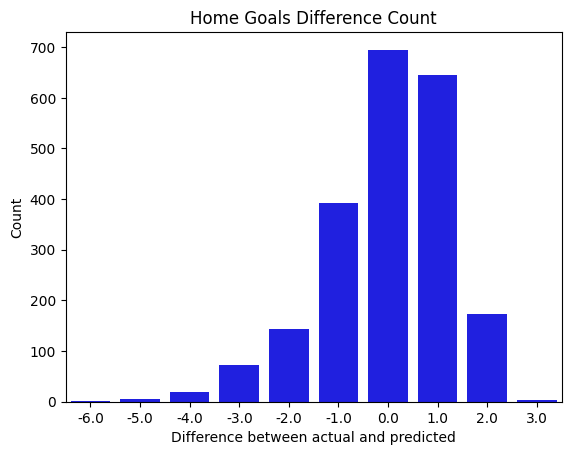

In [54]:
visualisations.histoplot(x_test, ha='Home')

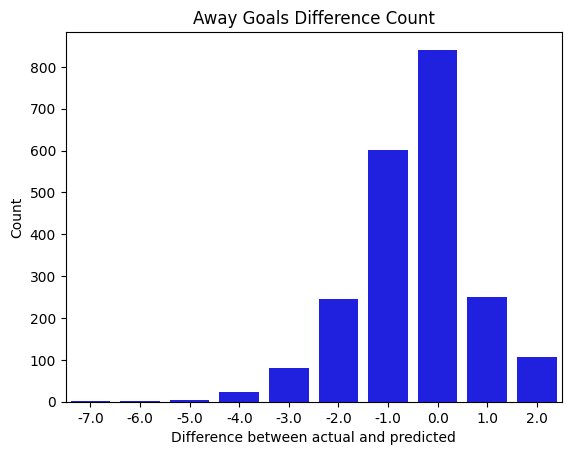

In [55]:
visualisations.histoplot(x_test, ha='Away')

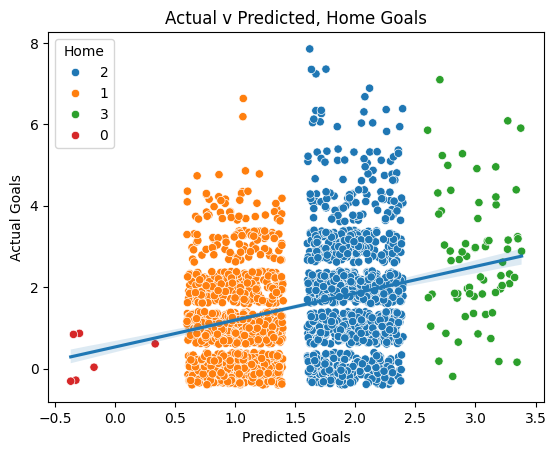

In [56]:
visualisations.actuals_predicted(x_test, ha='Home')

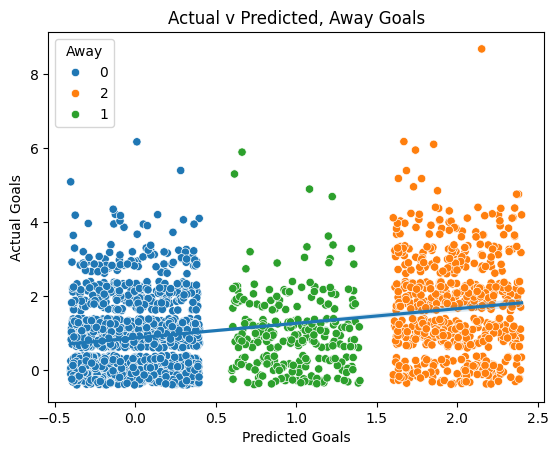

In [57]:
visualisations.actuals_predicted(x_test, ha='Away')

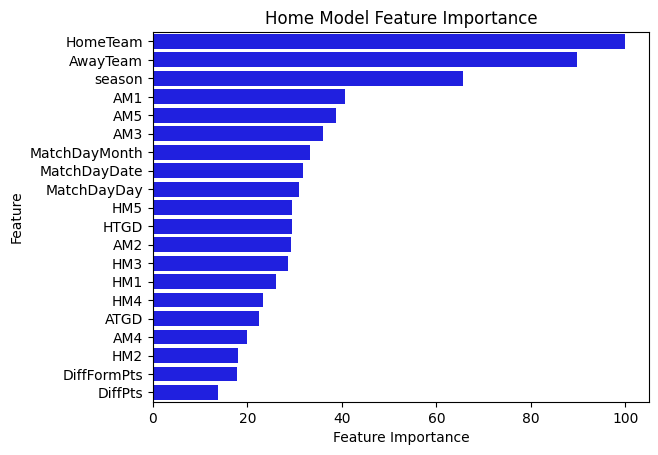

In [58]:
visualisations.plot_features(regressor_1, 'Home',n=20)

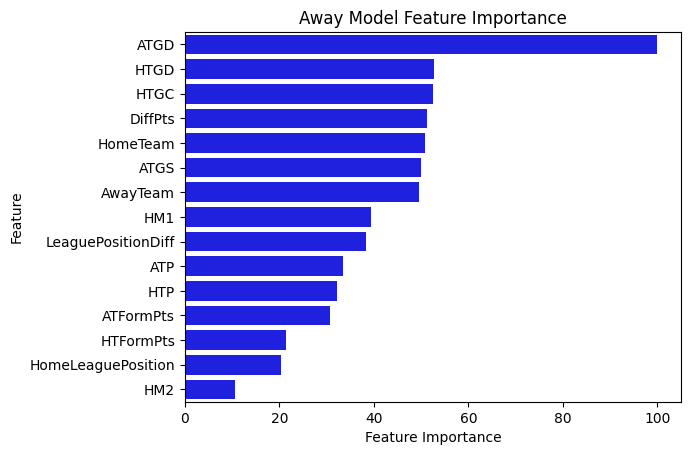

In [59]:
visualisations.plot_features(regressor_2, 'Away')